In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
import numpy as np
from kmodes import kprototypes
from sklearn.cluster import KMeans
import pickle
import pandas as pd
from datetime import date
from abc import abstractmethod
import os


def set_age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))


def set_sex(sex_str):
    if sex_str == 'female':
        return 0
    elif sex_str == 'male':
        return 1


def next_month(year, month):
    if month == 12:
        return year+1, 1
    else:
        return year, month+1

    
def get_activity_level(steps):
    if steps < 5000:
        return 0
    elif (steps >= 5000) and (steps < 10000):
        return 1
    elif steps >= 10000:
        return 2
    #elif (steps >= 10000) and (steps < 15000):
    #    return 3
    #elif (steps >= 10000) and (steps < 15000):
    #    return 4    
    #elif (steps >= 15000):
    #    return 5 
    
def get_age_group(age):
    if age < 30:
        return 0
    elif (age >= 30) and (age < 60):
        return 1
    else:
        return 2
    
def get_bmi_group(bmi):
    if bmi <= 18:
        return 0
    elif (bmi > 18) and (bmi <= 25):
        return 1
    elif (bmi > 25) and (bmi <= 30):
        return 2
    elif bmi > 30:
        return 3



class UsersClusters:

    def __init__(self, num_clusters, clustering_fields, data_dir='.'):
        with open(os.path.join(data_dir, 'bmi_steps.pickle'), 'rb') as f:
            self.bmi_steps = pd.DataFrame(pickle.load(f))
        with open(os.path.join(data_dir,'users_filter.pickle'), 'rb') as f:
            self.users = pd.DataFrame(pickle.load(f))

            self.users['age'] = self.users['birthday'].apply(lambda x: set_age(x))
            self.users['sex'] = self.users['sex'].apply(lambda x: set_sex(x))

            self.users_data = pd.merge(self.users, 
                                       self.user_entries_per_month(), on='user_id')
            
            self.users_data['activity_level'] = self.users_data['steps'].apply(
                lambda x: get_activity_level(x))
            self.users_data['bmi_group'] = self.users_data['bmi'].apply(
                lambda x: get_bmi_group(x))
            self.users_data['age_group'] = self.users_data['age'].apply(
                lambda x: get_age_group(x))
            
            self.rescale_info = {
                'age_group': {
                    'min': min(self.users_data['age_group']),
                    'range': max(self.users_data['age_group']) - min(self.users_data['age_group'])
                },
                'bmi_group': {
                    'min': min(self.users_data['bmi_group']),
                    'range': max(self.users_data['bmi_group']) - min(self.users_data['bmi_group'])
                },
                'activity_level': {
                    'min': min(self.users_data['activity_level']),
                    'range': max(
                        self.users_data['activity_level']) - min(
                        self.users_data['activity_level'])
                },
            }
            
            self.clustering_fields = clustering_fields
            self.cluster_data = np.array(self.users_data[clustering_fields])
            for c in range(len(clustering_fields)):
                self.cluster_data[:,c] = self.rescale_data(
                    self.cluster_data[:,c], clustering_fields[c] )
            
            self.clusters = self.find_clusters(num_clusters)
            
            self.centers = np.copy(self.clusters.cluster_centers_)
            for i in range(len(self.clustering_fields)):
                self.centers[:,i] = self.scale_data(self.centers[:,i], 
                                                    self.clustering_fields[i])


    @abstractmethod
    def find_clusters(self, num_clusters):
        return NotImplemented

    @abstractmethod
    def get_cluster(self, clustering_fields_values):
        return NotImplemented
    
    def get_centers(self):
        return self.centers
    
    def rescale_data(self, data_value, data_type):
        if data_type == 'sex':
            return data_value
        return (data_value - self.rescale_info[data_type]['min']) / (
            self.rescale_info[data_type]['range'])
    
    def scale_data(self, data_value, data_type):
        if data_type == 'sex':
            return data_value
        return (data_value * self.rescale_info[data_type]['range']) + (
            self.rescale_info[data_type]['min'])
    
    def user_entries_per_month(self):
        bmi_steps_month = self.bmi_steps.groupby(
            ['user_id', 'year', 'month'])['bmi', 'steps'].agg('mean')
        return bmi_steps_month.reset_index()

    def get_cluster_members(self, cluster_label):
        idx = [i for i, x in enumerate(self.clusters.labels_) if x == cluster_label]
        return self.users_data.iloc[idx]

    def recommender_user_sequence(self, clustering_fields_values, n_months):
        cluster_label = self.get_cluster(clustering_fields_values)
        cluster_members = self.get_cluster_members(cluster_label)
        return best_cluster_sequence(cluster_members, n_months)


class KMeansUsersClusters(UsersClusters):

    def find_clusters(self, num_clusters):
        clusters = KMeans(n_clusters=num_clusters)
        return clusters.fit(self.cluster_data)

    def get_cluster(self, clustering_fields_values):
        rescaled_data = [self.rescale_data(clustering_fields_values[k], 
                                k) for k in self.clustering_fields]
        return self.clusters.predict(np.array(
            [rescaled_data]))[0]



def is_ordered_sequence(seq):
    for i in range(len(seq) - 1):
        if (seq[i + 1]['year'], seq[i + 1]['month']) != next_month(
                seq[i]['year'], seq[i]['month']):
            return False
    return True


def get_user_sequences(user_entries, n_months):
    user_entries.sort_values(['year', 'month'])
    user_sequences = []
    for i in range(len(user_entries)-n_months):
        seq = []
        for j in range(n_months):
            seq.append(user_entries.iloc[i+j])
        if is_ordered_sequence(seq):
            user_sequences.append(seq)
    return user_sequences


def best_user_sequence(user_entries, n_months):
    user_sequences = get_user_sequences(user_entries, n_months)
    first = True
    best_seq = None
    best_corr = None
    for seq in user_sequences:
        df = pd.DataFrame(seq)
        if (df.bmi.std() < 0.01) or (df.steps.std() < 0.01):
            continue
        cur_corr = df[['bmi','steps']].corr()['bmi']['steps']
        if first:
            first=False
            best_seq = seq
            best_corr = cur_corr
        elif cur_corr < best_corr:
            best_seq = seq
            best_corr = cur_corr
    return best_seq, best_corr


def best_cluster_sequence(cluster_members, n_months):
    best_cluster_seq = None
    best_cluster_corr = None
    first = True
    for user_id in set(cluster_members.user_id):
        user_entries = cluster_members[cluster_members.user_id == user_id]
        best_seq, best_corr = best_user_sequence(user_entries, n_months)
        if best_corr is None:
            continue
        if first:
            first = False
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
        elif best_corr < best_cluster_corr:
            best_cluster_seq = best_seq
            best_cluster_corr = best_corr
    return best_cluster_seq, best_cluster_corr


if __name__ == "__main__":
    # Create Clusters
    number_of_clusters = 12
    clustering_fields = ['age_group', 'bmi_group', 'activity_level']
    users_clusters = KMeansUsersClusters(number_of_clusters, 
                                         clustering_fields, 
                                         data_dir='../data/filtered')

# Visualize clusters

3123
30179
14223
10682
7665
3847
2153
705
0
0
0
0


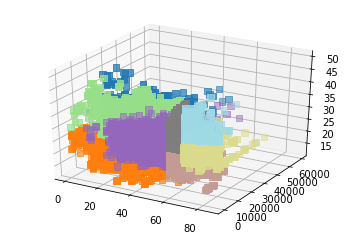

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

age = []
sex = []
bmi = []
steps = []
cluster = []
for i in range(number_of_clusters):
    members = users_clusters.get_cluster_members(i)
    print(len(members))
    age.extend(members.age)
    sex.extend(members.sex)
    bmi.extend(members.bmi)
    steps.extend(members.steps)
    cluster.extend([i] * len(members))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(age,steps,bmi, marker="s", c=cluster, s=40, cmap="tab20")
# ax.scatter(age,bmi,sex, marker="s", c=cluster, s=40)

plt.savefig('img/clusters.pdf')
plt.savefig('img/clusters.png')
plt.show()


72577

In [5]:
# Clusters summary
n_months = 6
clusters_summary = []
for i in range(number_of_clusters):
    cluster_members = users_clusters.get_cluster_members(i)
    best_seq, corr = best_cluster_sequence(cluster_members, n_months)
    cluster_summary = {
        'cluster_members': cluster_members,
        'cluster_center': users_clusters.get_centers()[i],
        'cluster_center_normalized': users_clusters.clusters.cluster_centers_[i],
        'best_seq': best_seq
    }
    clusters_summary.append(cluster_summary)
    
max_bmi = max(users_clusters.users_data.bmi)

In [16]:
# Visualization functions
color_schema = {
    'popoulation_color': 'royalblue',
    'user_color': 'mediumaquamarine',
    'bkg_color': 'lightsteelblue',
}

def visualize_bmi_steps(df_bmi_steps, savetofile=None):
    n_months = len(df_bmi_steps)
    x_ticks = [m for m in range(1,n_months+1)]
    
    fig, ax1 = plt.subplots()
    ax1.plot(x_ticks, df_bmi_steps['bmi'], 'b-')
    ax1.set_xlabel('month')

    ax1.set_ylabel('bmi', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(x_ticks, df_bmi_steps['steps'], 'g-')
    ax2.set_ylabel('steps', color='g')
    ax2.tick_params('y', colors='g')

    fig.tight_layout()
    if savetofile:
        plt.savefig(savetofile, bbox_inches='tight')
    plt.show()

# Histogram
def plot_histogram(sample_values, user_value = None, 
                   colors = color_schema, savetofile=None):
    bar_color = color_schema['popoulation_color']
    user_color = color_schema['user_color']
    n, bins, patches = plt.hist(sample_values, bins = 10, color = bar_color)
    if user_value:
        user_bin = min(range(len(bins)), 
               key=lambda i: abs(bins[i]-user_value))
        patches[user_bin].set_fc(user_color)
    if savetofile:
        plt.savefig(savetofile, bbox_inches='tight')
    plt.show()
    
def plot_boxplot(sample_values, user_value = None, colors = color_schema,
                savetofile=None):
    medianprops = dict(color = color_schema['popoulation_color'])
    plt.boxplot(sample_values, 0, medianprops=medianprops)
    plt.plot([1], user_value, 'o', c=color_schema['user_color'])
    if savetofile:
        plt.savefig(savetofile, bbox_inches='tight')
    plt.show()
    

def plot_donut(reference_values, labels, colors, color_idx, text, user_text=None, 
              savetofile=None):
    fig, ax = plt.subplots()
    ax.axis('equal')
    width = 0.35
    kwargs = dict(colors=colors, startangle=90)
    sizes = np.array(reference_values)/sum(reference_values)
    outside, _ = ax.pie(sizes, radius=1, labels=labels, pctdistance=1-width/2,**kwargs)
    plt.setp( outside, width=width, edgecolor='white')
    if user_text:
        text = text + '\n' + user_text
    kwargs = dict(size=15, color=colors[color_idx], fontweight='normal', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    if savetofile:
        plt.savefig(savetofile, bbox_inches='tight')
    plt.show()

def get_bmi_color_idx(bmi):
    if bmi <= 18:
        return 3
    elif (bmi > 18) and (bmi <= 25):
        return 2
    elif (bmi > 25) and (bmi <= 30):
        return 1
    elif bmi > 30:
        return 0
    
def visualize_user_results(input_values, idfile='', img_dir='', ext='png'):
    os.makedirs(os.path.dirname(img_dir), exist_ok=True)
    
    printmd('**Cluster info: **')
    cluster = users_clusters.get_cluster(input_values)
    cluster_members = clusters_summary[cluster]['cluster_members']
    cluster_center = clusters_summary[cluster]['cluster_center']
    cluster_best_seq = clusters_summary[cluster]['best_seq']
    bmi_steps = pd.DataFrame(cluster_best_seq)[['bmi','steps']]
    savetofile = os.path.join(img_dir, 'cluster_bmi_steps_user_{}.{}'.format(idfile,ext))
    visualize_bmi_steps(bmi_steps, savetofile=savetofile)
    
    
    #Visualize cluster center values
    
    #Bmi
    # reference_values = [18, 25, 30, 32]
    reference_values = [1, 1, 1, 1]
    # user_value = users_clusters.get_centers()[cluster][1]
    user_value = int(users_clusters.get_centers()[cluster][1])+1
    # user_value_str = "%.2f" % user_value
    user_value_str = str(user_value)
    colors = ['lightcoral', 'sandybrown', 'limegreen', 'lightcoral']
    labels = ['>30', '25-30', '18-25', '<18']
    texts = ['Underweight', 'Normal', 'Overweight', 'Obese']
    # color_idx = get_bmi_color_idx(user_value)
    color_idx = len(reference_values) - user_value
    savetofile = os.path.join(img_dir, 'cluster_center_bmi_user_{}.{}'.format(idfile,ext))
    # plot_donut(reference_values, labels, colors, color_idx, 
    #            texts[user_value-1], user_value_str, 
    #            savetofile=savetofile)
    plot_donut(reference_values, labels, colors, color_idx, texts[user_value-1],
          savetofile=savetofile)
    print(users_clusters.get_centers()[cluster])
    
    #Steps
    reference_values = [1, 1, 1]
    user_value = int(users_clusters.get_centers()[cluster][2])+1
    user_value_str = str(user_value)
    colors = ['limegreen', 'sandybrown', 'lightcoral']
    labels = ['>10000', '5000-10000', '<5000']
    texts = ['Low active', 'Active', 'Very active']
    color_idx = len(reference_values) - user_value
    savetofile = os.path.join(img_dir, 'cluster_center_steps_user_{}.{}'.format(idfile,ext))
    plot_donut(reference_values, labels, colors, color_idx, texts[user_value-1],
              savetofile=savetofile)
    print(users_clusters.get_centers()[cluster])

    print('* Bmi')
    savetofile = os.path.join(img_dir, 'cluster_bmi_histogram_user_{}.{}'.format(idfile,ext))
    plot_histogram(cluster_members['bmi'].values, input_values['bmi'],
                  savetofile=savetofile)
    savetofile = os.path.join(img_dir, 'cluster_bmi_boxplot_user_{}.{}'.format(idfile,ext))
    plot_boxplot(cluster_members['bmi'].values, input_values['bmi'],
                savetofile=savetofile)


    print('* Steps')
    savetofile = os.path.join(img_dir, 
                              'cluster_steps_histogram_user_{}.{}'.format(idfile,ext))
    plot_histogram(cluster_members['steps'].values, input_values['steps'],
                  savetofile=savetofile)
    savetofile = os.path.join(img_dir, 'cluster_steps_boxplot_user_{}.{}'.format(idfile,ext))
    plot_boxplot(cluster_members['steps'].values, input_values['steps'],
                savetofile=savetofile)

    print('* Age')
    savetofile = os.path.join(img_dir, 'cluster_age_histogram_user_{}.{}'.format(idfile,ext))
    plot_histogram(cluster_members['age'].values, input_values['age'],
                  savetofile=savetofile)
    savetofile = os.path.join(img_dir, 'cluster_age_boxplot_user_{}.{}'.format(idfile,ext))
    plot_boxplot(cluster_members['age'].values, input_values['age'],
                savetofile=savetofile)
    

    

# Test on given input data

**Cluster info: **


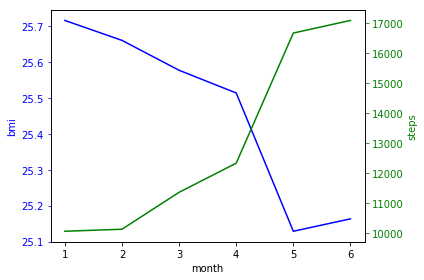

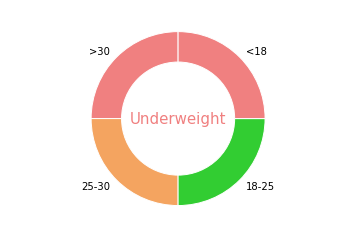

[  4.34097203e-14   1.76192394e-13   2.00000000e+00]


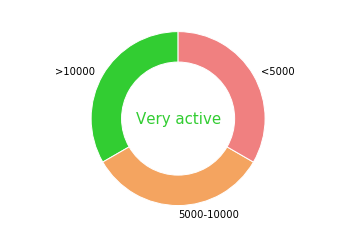

[  4.34097203e-14   1.76192394e-13   2.00000000e+00]
* Bmi


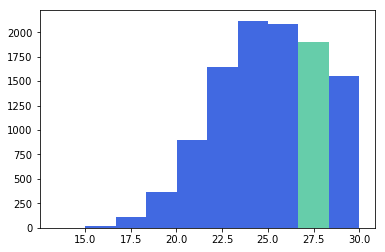

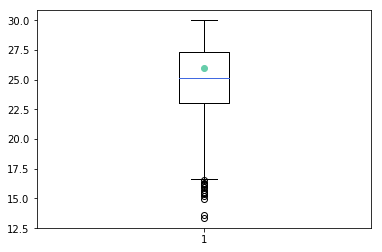

* Steps


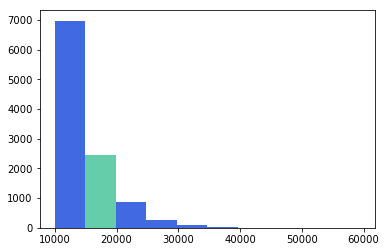

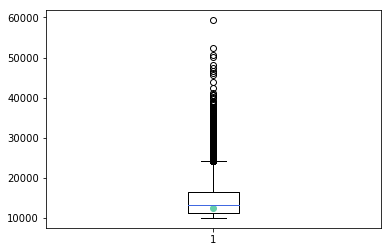

* Age


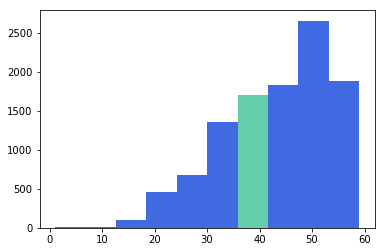

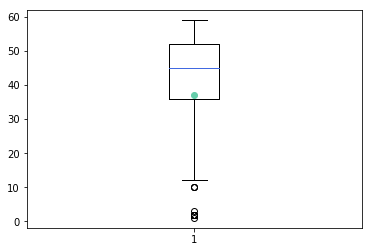

In [19]:
input_values = {
    'age_group': 1,
    'age': 37,
    'bmi_group': 1,
    'bmi': 26,
    'activity_level': 2,
    'steps': 12500,
}

visualize_user_results(input_values, '1', 'img/1/')

# Test on user data

**Cluster info: **


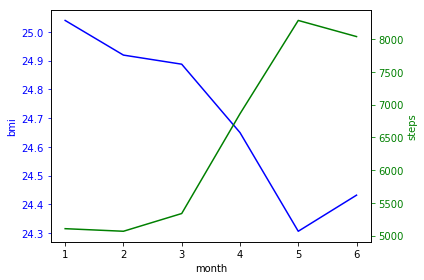

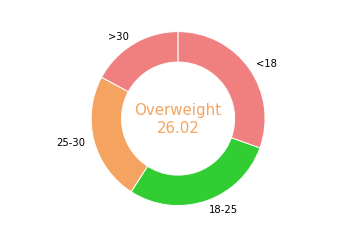

[ 52.80198777  26.02246429   1.        ]


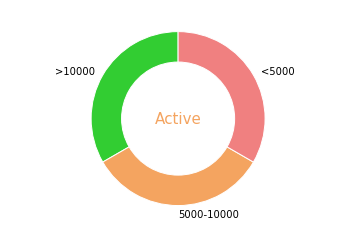

[ 52.80198777  26.02246429   1.        ]
* Bmi


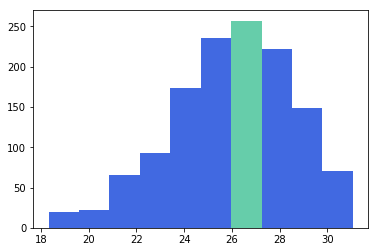

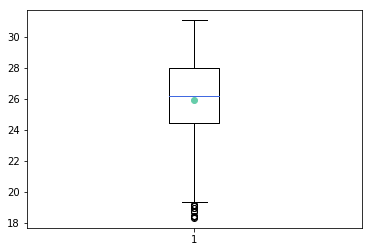

* Steps


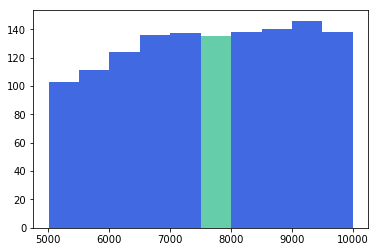

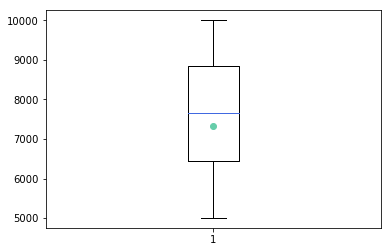

* Age


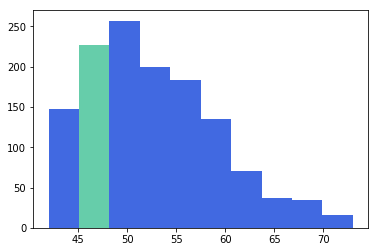

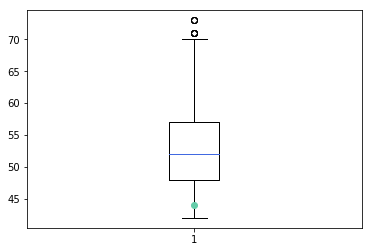

In [537]:
user_id = '2a786a87-f00b-461a-90cd-c1a7a9a06f2e'
year = 2016
month = 2

user_data = users_clusters.users_data[
    (users_clusters.users_data.user_id == user_id) &
    (users_clusters.users_data.year == year) &
    (users_clusters.users_data.month == month)]

input_values = {
    'age': user_data['age'].values[0],
    'bmi': user_data['bmi'].values[0],
    'activity_level': user_data['activity_level'].values[0],
    'steps': user_data['steps'].values[0]
}


visualize_user_results(input_values, '2', 'img/2/')